In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import os
import math
from ast import literal_eval
from collections import defaultdict
from matplotlib_venn import venn3, venn3_circles

# Datasets

## Genres and Platforms

In [2]:
df_genres = pd.read_csv('../genres.csv', header=None)
df_genres.columns = ['genre_id', 'genre_name']

df_platforms = pd.read_csv('../platforms.csv', header=None)
df_platforms.columns = ['platform_id', 'platform_name']

list_platform_ps = ['PlayStation 4', 'PlayStation 3', 'PlayStation 2', 'PlayStation', 'PlayStation Vita', 'PlayStation Portable']
list_platform_xbox = ['Xbox One', 'Xbox 360', 'Xbox', 'Xbox Live Arcade']
list_platform_pc = ['PC (Microsoft Windows)', 'PC DOS', 'Mac', 'Linux']

# show genres columns
df_genres.head()

,genre_id,genre_name
0,4,Fighting
1,5,Shooter
2,7,Music
3,8,Platform
4,9,Puzzle


## HLTB

In [3]:
if not os.path.exists('dataset_hltb.csv'):

    PATH = '../igdb_scarper/hl2b/'

    dataset_hltb = pd.DataFrame()
        
    for file in os.listdir(PATH):

        try:
            df = pd.read_csv(PATH + '/' + file, lineterminator='\n', encoding="utf-8",)
            dataset_hltb = pd.concat([dataset_hltb, df])
        except pd.errors.EmptyDataError:
            print(file, " is empty and has been skipped.")    
            # pass

    dataset_hltb = dataset_hltb.drop(columns=['Unnamed: 0'])    
    dataset_hltb = dataset_hltb.drop_duplicates(subset=['name'], keep='first')

    dataset_hltb.to_csv('dataset_hltb.csv', index=False, encoding='utf-8', lineterminator='\n')

dataset_hltb.info()


<class 'pandas.core.frame.DataFrame'>
Index: 97832 entries, 0 to 141
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           97831 non-null  object 
 1   title_found    97832 non-null  object 
 2   main           97832 non-null  float64
 3   extra          97832 non-null  float64
 4   completionist  97832 non-null  float64
 5   review_score   97832 non-null  int64  
 6   review_count   97832 non-null  int64  
 7   people_polled  97832 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 6.7+ MB


## IGDB

In [5]:
if not os.path.exists('dataset_igdb.csv'):

    PATH = '../igdb_scarper/IGDB_metadata/'

    dataset = pd.DataFrame()
    for platform in os.listdir(PATH):
        # print(platform)

        df_platform = pd.DataFrame()
        
        for file in os.listdir(PATH + platform):

            try:
                df_platform = pd.read_csv(PATH + platform + '/' + file, lineterminator='\n', encoding="utf-8")
                dataset = pd.concat([dataset, df_platform])
            except pd.errors.EmptyDataError:
                # print(file, " is empty and has been skipped.")    
                pass

    dataset['first_release_date'] = pd.to_datetime(dataset['first_release_date'], unit='s')

    # remove the duplicated ids
    dataset = dataset.drop_duplicates(subset=['id'], keep='first')
    
    dataset.to_csv('dataset_igdb.csv', index=False, encoding='utf-8', lineterminator='\n')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99864 entries, 0 to 51
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   first_release_date  99864 non-null  datetime64[ns]
 1   id                  99864 non-null  int64         
 2   name                99863 non-null  object        
 3   platforms           99864 non-null  object        
 4   summary             99863 non-null  object        
 5   genres              99863 non-null  object        
 6   storyline           99419 non-null  object        
 7   rating              63808 non-null  object        
             3197 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 7.6+ MB


## IGDB + HLTB

In [37]:
if not os.path.exists('dataset_igdb_hltb.csv'):

    dataset_hltb = pd.read_csv('dataset_hltb.csv', lineterminator='\n', encoding="utf-8")

    dataset = pd.read_csv('dataset_igdb.csv', lineterminator='\n', encoding="utf-8")

    # concatenate the two datasets
    dataset = pd.merge(dataset, dataset_hltb, how='left', left_on='name', right_on='name')

    dataset.to_csv('dataset_igdb_hltb.csv', index=False, encoding='utf-8', lineterminator='\n')

else:
    dataset = pd.read_csv('dataset_igdb_hltb.csv', lineterminator='\n', encoding="utf-8",
                            converters={"id": str, 
                                        "first_release_date": pd.to_datetime,
                                        "platforms": literal_eval,
                                        "genres": lambda x: x.strip("[]").split(", ") if x != 'Missing' else 'Missing'
                                        })

dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99864 entries, 0 to 99863
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   first_release_date  99864 non-null  datetime64[ns]
 1   id                  99864 non-null  object        
 2   name                99863 non-null  object        
 3   platforms           99864 non-null  object        
 4   summary             99863 non-null  object        
 5   genres              99864 non-null  object        
 6   storyline           99419 non-null  object        
 7   rating              63808 non-null  object        
             3197 non-null   object        
 9   title_found         99864 non-null  object        
 10  main                99864 non-null  float64       
 11  extra               99864 non-null  float64       
 12  completionist       99864 non-null  float64       
 13  review_score        99864 non-null  int64         
 14  re

In [38]:
# Total number of games
print("Total number of games: ", dataset.shape[0])

Total number of games:  99864


# Platform

## Games per platform

In [39]:
# number of games per platform
games_per_platform = dataset['platforms'].apply(lambda x: x[0]).value_counts().sort_values(ascending=False)

games_per_platform = pd.DataFrame(games_per_platform).reset_index().rename(columns={'platforms': 'platform_id'})
games_per_platform['platform_id'] = games_per_platform['platform_id'].astype(int)
games_per_platform = games_per_platform.merge(df_platforms, on='platform_id', how='left')
games_per_platform.sort_values(by='count', ascending=False)

games_per_platform['count'].sum()
games_per_platform


,platform_id,count,platform_name
0,6,64274,PC (Microsoft Windows)
1,3,9403,Linux
2,130,4653,Nintendo Switch
3,48,2980,PlayStation 4
4,8,2603,PlayStation 2
5,7,2259,PlayStation
6,20,2166,Nintendo DS
7,9,1501,PlayStation 3
8,49,1372,Xbox One
9,37,1308,Nintendo 3DS


## Single platform games (exclusives)

In [11]:

# only single platform games
dataset[dataset['platforms'].apply(lambda x: len(x) == 1)]

# show only the single platform games in their respective platform
games_single_platform = dataset[dataset['platforms'].apply(lambda x: len(x) == 1)]['platforms'].apply(lambda x: x[0]).value_counts()

games_single_platform = pd.DataFrame(games_single_platform).reset_index().rename(columns={'platforms': 'platform_id'})
games_single_platform['platform_id'] = games_single_platform['platform_id'].astype(int)
games_single_platform = games_single_platform.merge(df_platforms, on='platform_id', how='left')
games_single_platform.sort_values(by='count', ascending=False)

# total number of single platform games
print("Total number of single platform games: ", games_single_platform['count'].sum())


Total number of single platform games:  61526


# Genres

## Games per genre

In [40]:
# remove values missing values in a column
dataset['genres'].replace('Missing', np.nan, inplace=True)
# replace '' with np.nan
dataset['genres'].replace('', np.nan, inplace=True)

print("Number of games with missing genres: ", dataset['genres'].isnull().sum())

dataset['genres'].sort_values(ascending=True)

Number of games with missing genres:  9048


7900       []
31527    [10]
86329    [10]
33819    [10]
2472     [10]
         ... 
99825     NaN
99826     NaN
99830     NaN
99844     NaN
99853     NaN
Name: genres, Length: 99864, dtype: object

In [43]:
# remove genres values missing values
dataset_no_nas = dataset.dropna(subset=['genres'])
# remove lists with empty strings
dataset_no_nas = dataset_no_nas[dataset_no_nas['genres'].apply(lambda x: x[0] != '')]

games_per_genre = dataset_no_nas['genres'].apply(lambda x: x[0]).value_counts().sort_values(ascending=False)

games_per_genre = pd.DataFrame(games_per_genre).reset_index().rename(columns={'genres': 'genre_id'})
games_per_genre['genre_id'] = games_per_genre['genre_id'].astype(int)
games_per_genre = games_per_genre.merge(df_genres, on='genre_id', how='left')
games_per_genre.sort_values(by='count', ascending=False)

games_per_genre['count'].sum()
games_per_genre


,genre_id,count,genre_name
0,31,11507,Adventure
1,5,11000,Shooter
2,12,10932,Role-playing (RPG)
3,13,10760,Simulator
4,32,8295,Indie
5,9,7185,Puzzle
6,8,6509,Platform
7,15,4866,Strategy
8,10,3916,Racing
9,4,2876,Fighting


## RPG venn

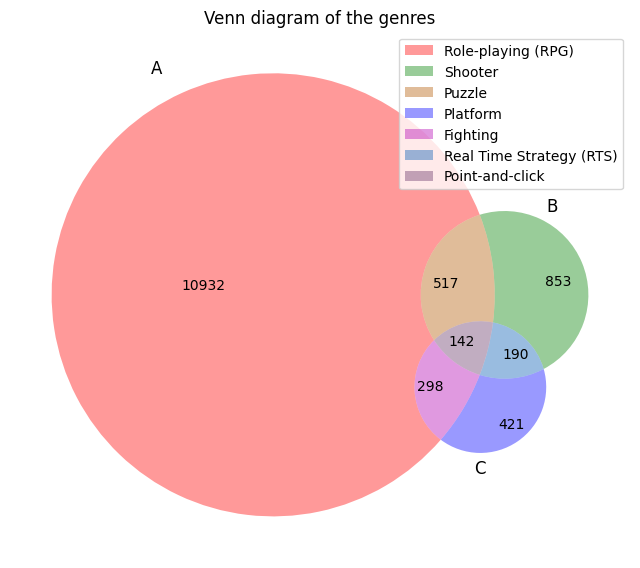

In [46]:
# list all games that contains the genre '12' in the list of genres
dataset_rpg = dataset_no_nas[dataset_no_nas['genres'].apply(lambda x: '12' in x)]

# venn diagram with the genres in the dataset_rpg
games_per_genre_rpg = dataset_rpg['genres'].apply(lambda x: x[0]).value_counts().sort_values(ascending=False)

games_per_genre_rpg = pd.DataFrame(games_per_genre_rpg).reset_index().rename(columns={'genres': 'genre_id'})
games_per_genre_rpg['genre_id'] = games_per_genre_rpg['genre_id'].astype(int)
games_per_genre_rpg = games_per_genre_rpg.merge(df_genres, on='genre_id', how='left')
games_per_genre_rpg.sort_values(by='count', ascending=False)

games_per_genre_rpg

# venn diagram
fig = plt.figure(figsize=(8, 8))
venn3(subsets=(games_per_genre_rpg['count'][0], 
               games_per_genre_rpg['count'][1], 
               games_per_genre_rpg['count'][2], 
               games_per_genre_rpg['count'][3], 
               games_per_genre_rpg['count'][4], 
               games_per_genre_rpg['count'][5], 
               games_per_genre_rpg['count'][6]))

# add title
plt.title("Venn diagram of the genres")

# add legend
plt.legend(games_per_genre_rpg['genre_name'].tolist())

# show plot
plt.show()


In [139]:
# show only the games with genres 12 and 4
dataset_no_nas[dataset_no_nas['genres'].apply(lambda x: '12' in x and '4' in x)]


,first_release_date,id,name,platforms,summary,genres,storyline,rating,rating\r
47,2010-07-13,2249,DeathSpank,"[3, 6, 9, 12, 14]",This game follows the thongtastic adventures o...,"[4, 12, 25, 31, 32]",For uncounted years DeathSpank has been a Disp...,77.88958538562048,NaN
262,2015-09-04,12513,Rampage Knights,"[6, 14, 130]",Rampage Knights is a cooperative beat em up ga...,"[4, 12, 25, 31, 32, 33]",Missing,79.75375631559575,NaN
420,2015-09-11,28031,Destiny Warriors,[6],Destiny Warriors is an epic 12 hour JRPG inspi...,"[4, 12, 31, 32]",Missing,40.0,NaN
962,2023-02-28,216514,The Excrawlers,"[6, 49, 130, 169]",ActionRPG roguelike game in which you and othe...,"[4, 12, 31, 32]",Missing,NaN,NaN
1896,2018-05-16,102107,Son of a Witch,"[6, 130]",Action roguelike for 14 players with cute grap...,"[4, 12, 25, 31, 33]",Missing,NaN,NaN
...,...,...,...,...,...,...,...,...,...
99248,2020-02-06,113378,Granblue Fantasy: Versus,"[6, 48]",Embark on a new fight O champions of the skies...,"[4, 12]",In the RPG Mode Granblue Fantasy Versus featur...,79.97800524642484,NaN
99293,1998-07-23,43816,Blue Breaker Burst: Bishou o Anata to,[7],Chimena wishes to rid herself and the world of...,"[4, 12]",Missing,Missing,NaN
99421,2014-04-03,146382,Drakengard 3: Zero's Prologue,[9],A prequel to the main chapters of the game abo...,"[4, 12, 25, 31]",Missing,Missing,NaN
99461,2015-11-16,42944,Tales of Zestiria: Collector's Edition,"[9, 48]",The game revolves around Sorey who wishes to r...,"[4, 12, 31]",Missing,Missing,NaN


# Year

## Games per Year

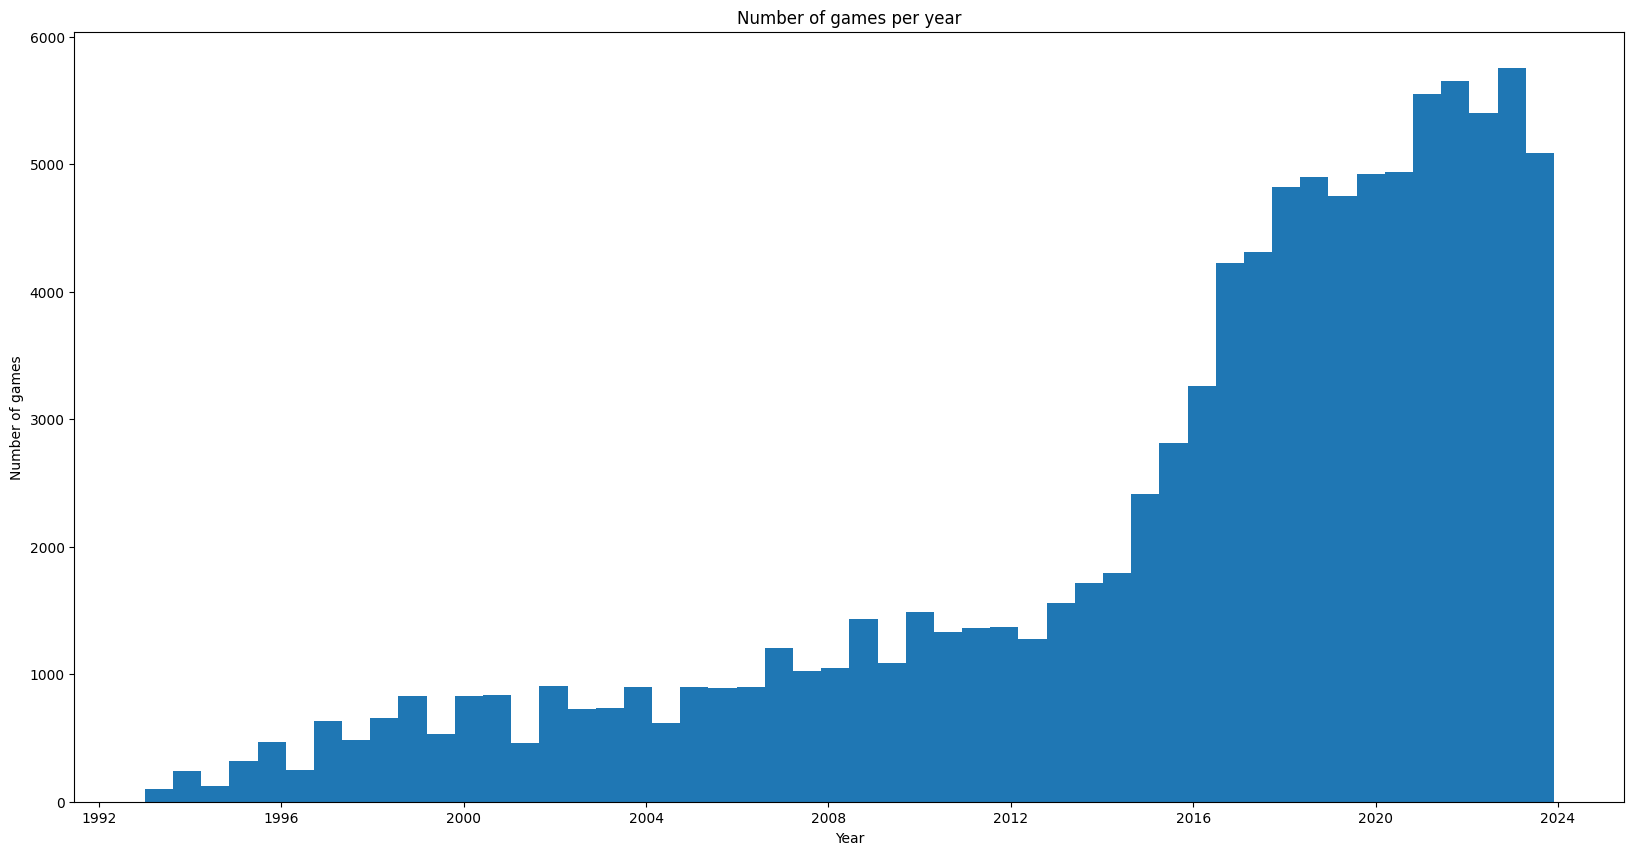

,year,count
30,2023,7677
29,2022,9018
28,2021,9049
27,2020,8282
26,2019,7739
25,2018,7814
24,2017,7238
23,2016,6127
22,2015,4503
21,2014,3203


In [47]:
# plot the games per year
plt.figure(figsize=(20,10))
plt.hist(dataset['first_release_date'], bins=50)
plt.xlabel('Year')
plt.ylabel('Number of games')
plt.title('Number of games per year')
plt.show()

# table with the number of games per year
games_per_year = dataset['first_release_date'].dt.year.value_counts().sort_index().reset_index()
games_per_year.columns = ['year', 'count']
games_per_year['year'] = games_per_year['year'].astype(int)
games_per_year.sort_values(by='year', ascending=False)